### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import gamma as gamma_func
from scipy.stats import norm
from scipy.stats import gamma
import seaborn as sns

### Simple Variational Inference 

#### Data generator function

In [2]:
def generate_data(mu, sigma, N):
    """ Generates data from a Gaussian with given expectation (mu) and
    spread/standard deviation (sigma).

    Parameters
    ----------
    mu : float
        Expectation, or mean, of the Gaussian distribution over the data.
    sigma : float
        Measure of spread, or standard deviation, of the Gaussian
        distribution over the data.

    Returns
    -------
    np.ndarray
        Numpy array of shape (N,) with normally distrubuted data.
    """
    return np.random.normal(loc=mu, scale=sigma, size=N)

#### Factors of the factorized variational approximation, q, to the posterior distribution

In [3]:
def q_mu(mu_vec, mu, lambda_):
    """ Defines the probability density over mu, that is, the factor
    for the expectation, or mean, mu (of the Gaussian) in the factorized
    variational approximation, q, to the posterior distribution.

    Parameters
    ----------
    mu_vec : np.ndarray
        Numpy array (1D) of mu points for which the probbaility
        density is computed. Commonly used for points coming from np.linspace.
    mu : float
        The expectation, or mean, of the Gaussian over mu.
    lambda_ : float
        The precision of the Gaussian over mu.

    Returns
    -------
    np.ndarray
        Numpy array of shape (mu_vec.shape[0],) with the probability density
        values of the points in mu_vec.
    """
    # Get the standard deviation, sigma, from the precision prec.
    sigma = np.sqrt(1/lambda_)
    
    return norm.pdf(mu_vec, loc=mu, scale=sigma)


def q_tau(tau_vec, a, b):
    """ Defines the probability density over tau, that is, the factor for
    the precision (=1/sigma**2) prec (of the Gaussian) in the factorized
    variational approximation, q, to the posterior distribution.

    Parameters
    ----------
    tau_vec : np.ndarray
        Numpy array (1D) of tau points for which the probbaility density is
        computed. Commonly used for points coming from np.linspace.
    a : float
        The alpha parameter of the Gamma distribution over tau.
    b : float
        The beta parameter of the Gamma distribution over tau.

    Returns
    -------
    np.ndarray
        Numpy array of shape (tau_vec.shape[0],) with the probability
        density values of the points in tau_vec.
    """
    return gamma.pdf(tau_vec, a=a, loc=0, scale=1/b)

#### Updating the parameters of the factors of the factorized variational approximation, q, to the posterior distribution

In [4]:
def update_q_mu(x, a_n, b_n, mu_0, lambda_0):
    """ Updates the parameters of the probability density over mu, that is,
    the factor for the expectation, or mean, mu (of the Gaussian) in the
    factorized variational approximation, q, to the posterior distribution.

    Parameters
    ----------
    x : np.ndarray
        Numpy array (1D) of the normal distributed data.
    a_n : float
        The alpha parameter of the Gamma distribution over tau.
        Keeps being updated during the optimization.
    b_n : float
        The beta parameter of the Gamma distribution over tau.
        Keeps being updated during the optimization.
    mu_0 : float
        The initial, starting value of the expectation, or mean,
        of the Gaussian over mu.
    lambda_0 : float
        The initial, starting value of the precision of the Gaussian over mu.

    Returns
    -------
    mu_n : float
        The updated value of the expectation, or mean, of the Gaussian over mu.
    lambda_n : float
        The updated value of the precision of the Gaussian over mu.
    """
    # Number of data points.
    n_data = x.shape[0]

    # Expectation of gamma distribution over tau.
    expected_tau = a_n / b_n

    # Updated precision of q_mu.
    lambda_n = expected_tau * (n_data + lambda_0)

    # Updated expectation of q_mu.
    mu_n = \
        (n_data * np.mean(x)
         + lambda_0 * mu_0) / (n_data + lambda_0)

    return mu_n, lambda_n


def update_q_tau(x, mu_n, lambda_n, a_0, b_0, mu_0, lambda_0):
    """ Updates the parameters of the probability density over over tau,
    that is, the factor for the precision (=1/sigma**2) prec (of the Gaussian)
    in the factorized variational approximation, q, to the posterior
    distribution.

    Parameters
    ----------
    x : np.ndarray
        Numpy array (1D) of the normal distributed data.
    mu_n : float
        The expectation, or mean, of the Gaussian over mu.
        Keeps being updated during the optimization.
    lambda_n : float
        The precision of the Gaussian over mu.
        Keeps being updated during the optimization.
    a_0 : float
        The initial, starting value of the alpha parameter
        of the Gamma distribution over tau.
    b_0 : float
        The initial, starting value of the beta parameter
        of the Gamma distribution over tau.
    mu_0 : float
        The initial, starting value of the expectation, or mean,
        of the Gaussian over mu.
    lambda_0 : float
        The initial, starting value of the precision of the Gaussian over mu.

    Returns
    -------
    a_n : float
        The alpha parameter of the Gamma distribution over tau.
    b_n : float
        The beta parameter of the Gamma distribution over tau.
    """
    # Number of data points.
    n_data = x.shape[0]

    # Updated a of q_tau.
    # +1 in brackets in lecture notes, but not in Bishop.
    a_n = a_0 + (n_data + 1) / 2

    # Expectation of normal distribution over mu.
    expected_mu = mu_n

    # Expectation of squared mu in normal distribution over mu.
    expected_squared_mu = lambda_n**(-1) + expected_mu**2

    # Sum of squared data points.
    sum_of_squared_x = np.sum(np.power(x, 2))

    # Sum of data points.
    sum_of_x = np.sum(x)

    # Updated b of q_tau.
    b_n = \
        b_0 \
        + 0.5*(sum_of_squared_x + lambda_0*mu_0**2
               - 2*expected_mu*(sum_of_x + mu_0*lambda_0)
               + expected_squared_mu * (lambda_0 + n_data))

    return a_n, b_n

#### Computing the parameters of the exact normal-gamma posterior, and generating the posterior for comparing with the posteiror estimated by VI

In [5]:
def exact_posterior_params(x, a_0, b_0, mu_0, lambda_0):
    """ Computes the parameters of the exact normal-gamma
    posterior over mu, the expectation of the data, and tau,
    the precision of the data.

    Parameters
    ----------
    x : np.ndarray
        Numpy array (1D) of the normal distributed data.
    a_0 : float
        The initial, starting value of the alpha parameter
        of the Gamma distribution over tau.
    b_0 : float
        The initial, starting value of the beta parameter
        of the Gamma distribution over tau.
    mu_0 : float
        The initial, starting value of the expectation, or mean,
        of the Gaussian over mu.
    lambda_0 : float
        The initial, starting value of the precision of the Gaussian over mu.

    Returns
    -------
    mu_t : float
        The exact expectation, or mean, of the Gaussian over mu in the
        exact normal-gamma over mu and tau.
    lambda_n : float
        The exact precision of the Gaussian over mu in the
        exact normal-gamma over mu and tau.
    a_t : float
        The exact alpha parameter of the Gamma distribution over tau in the
        exact normal-gamma over mu and tau.
    b_t : float
        The beta parameter of the Gamma distribution over tau in the
        exact normal-gamma over mu and tau.
    """
    # Number of data points.
    n_data = x.shape[0]

    # The expecation, or mean, of the data.
    x_bar = np.mean(x)

    # The mu parameter in the exact normal-gamma.
    mu_t = (lambda_0 * mu_0 + n_data * x_bar) / (lambda_0 + n_data)

    # The lambda parameter in the exact normal-gamma.
    lambda_t = lambda_0 + n_data

    # The alpha parameter in the exact normal-gamma.
    a_t = a_0 + n_data/2

    # The beta parameter in the exact normal-gamma.
    b_t = b_0 + 0.5*(lambda_0*mu_0**2 
                     - lambda_t*mu_t**2 + np.sum(np.power(x, 2)))

    return mu_t, lambda_t, a_t, b_t


def exact_posterior_dist(mu_vec_, tau_vec_, mu_t, lambda_t, a_t, b_t):
    """ Computes the exact normal-gamma posterior over mu and tau,
    paramerized by the exact parameters. Used to compare the
    posterior distribution estimated by variational inference.

    Parameters
    ----------
    mu_vec_ : np.ndarray
        Numpy array (1D) of mu points for which the probbaility
        density is computed. Commonly used for points coming from np.linspace.
    tau_vec_ : np.ndarray
        Numpy array (1D) of tau points for which the probbaility density is
        computed. Commonly used for points coming from np.linspace.
    mu_t : float
        The exact expectation, or mean, of the Gaussian over mu in the
        exact normal-gamma over mu and tau.
    lambda_n : float
        The exact precision of the Gaussian over mu in the
        exact normal-gamma over mu and tau.
    a_t : float
        The exact alpha parameter of the Gamma distribution over tau in the
        exact normal-gamma over mu and tau.
    b_t : float
        The beta parameter of the Gamma distribution over tau in the
        exact normal-gamma over mu and tau.

    Returns
    -------
    numpy.ndarray
        A numpy array (2D) of shape (mu_vec_.shape[0], tau_vec_.shape[0]).
        Stores the exact normal-gamma posteriro probability density value
        for each combination of the mu_vec_ and the tau_vec_ values.
    """
    # Convert mu_vec_ and tau_vec_ to 2D numpy arrays for creating the
    # probability density for each combination of the mu and tau values.
    mu_vec = mu_vec_.reshape(-1, 1)
    tau_vec = tau_vec_.reshape(-1, 1)

    # Compute the exact normal-gamma posterior using the data x.
    # Compute the constant term.
    constant = \
        (b_t**a_t * np.sqrt(lambda_t)) / (gamma_func(a_t) * np.sqrt(2*np.pi))

    # Compute the terms with tau only.
    term_1 = np.power(tau_vec, a_t - 0.5)
    term_2 = np.exp(-b_t * tau_vec)

    # Compute the term with both tau and mu. Use np.matmul and
    # np.transpose to get all the cominations of the mu and tau values.
    term_3 = \
        np.exp(-0.5*lambda_t *
               np.matmul(tau_vec, (np.transpose(mu_vec)-mu_t)**2))

    # Return the piece-wise products between the terms and get a 2D numpy
    # array of shape (mu_vec_.shape[0], tau_vec_.shape[0]).
    return constant * term_1 * term_2 * term_3

#### Convergence criteria: when all of the parameters of the estimated normal-gamma posterior have converged

In [6]:
def if_converged(mu_n_register, lambda_n_register, a_n_register,
                 b_n_register, thresh):
    """ Checks if the VI algorithm has converged. Compares the last two values
    of each parameter of the estimated normal-gamma posterior, and if their
    difference is below the threshold thresh, then the VI has converged.

    Parameters
    ----------
    mu_n_register : list
        List of the updated values of the expectation of the
        normal distribution over mu.
    lambda_n_register : list
        List of the updated values of the precision of the
        normal distribution over mu.
    a_n_register : list
        List of the updated values of the alpha parameter of the
        gamma distribution over tau.
    b_n_register : list
        List of the updated values of the beta parameter of the
        gamma distribution over tau.
    thresh : float
        The threshold of convergence for the difference bewteen
        the last two values for each parameter in the estimated
        normal-gamma posterior distribution over mu and tau.

    Returns
    -------
    bool
        True if the VI has converged, that is, each parameter converged.
    """
    mu_n_converged = np.abs(mu_n_register[-1] - mu_n_register[-2]) < thresh
    lambda_n_converged = \
        np.abs(lambda_n_register[-1] - lambda_n_register[-2]) < thresh
    a_n_converged = np.abs(a_n_register[-1] - a_n_register[-2]) < thresh
    b_n_converged = np.abs(b_n_register[-1] - b_n_register[-2]) < thresh

    return mu_n_converged and lambda_n_converged and \
        a_n_converged and b_n_converged

### Generate data and visualize its distribution

In [7]:
# Set the random seed for reproducibility.
np.random.seed(200)

# Specify the number of data points.
N_data = 5

# Specify the mean of the data.
mean_data = -2

# Specify the precision of the data, and convert it to standard deviation.
prec_data = 2
sigma_data = np.sqrt(1/prec_data)

# Generate data.
x = generate_data(mu=mean_data, sigma=sigma_data, N=N_data)
print(f"Data (N={N_data}):")
print(x)

Data (N=5):
[-3.02597535 -0.64875208 -1.49662542 -2.17517742 -1.74440477]


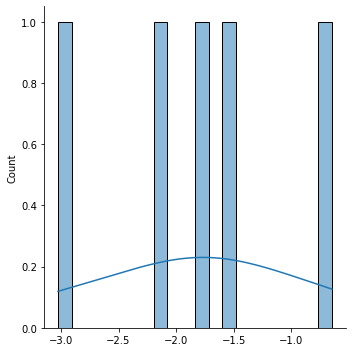

In [8]:
# Visualize data distribution.
sns.displot(data=x, bins=20, kde=True)
plt.show()

### The VI algorithm for finding the estimated normal-gamma posterior distribution over mu and tau, and the posterior over the data.

Data drawn from normal distribution with mean=-2, prec=2, number of points=5

[EXACT POSTERIOR]
mu_t = -1.8182, lambda_t = 5.0000 a_t = 2.5000, b_t = 1.5313
E[mu]=-1.8182, E[tau]=1.6326 

[VI ITER: 0, CONVERGENCE: no]
mu_n = -1.8182, lambda_n = 0.4311, a_n = 3.0000, b_n = 34.7958
E[mu] = -1.8182, E[tau] = 0.0862



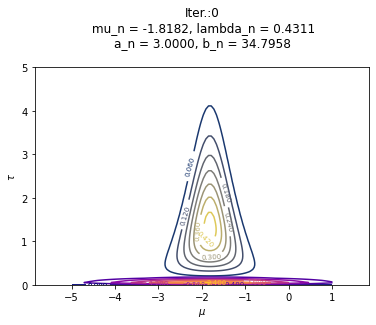

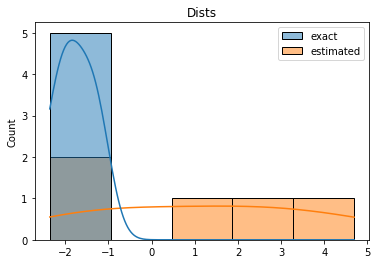

[VI ITER: 1, CONVERGENCE: no]
mu_n = -1.8182, lambda_n = 2.0462, a_n = 3.0000, b_n = 7.3306
E[mu] = -1.8182, E[tau] = 0.4092



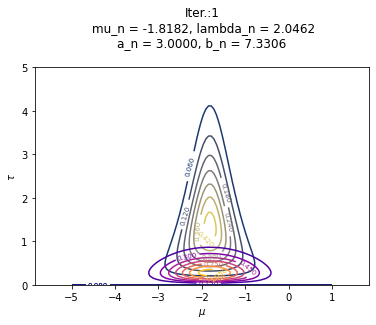

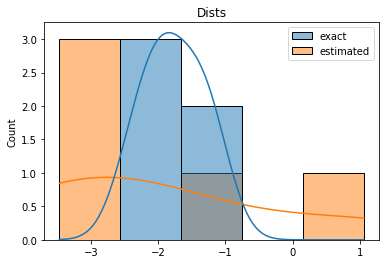

[VI ITER: 2, CONVERGENCE: no]
mu_n = -1.8182, lambda_n = 5.4484, a_n = 3.0000, b_n = 2.7531
E[mu] = -1.8182, E[tau] = 1.0897



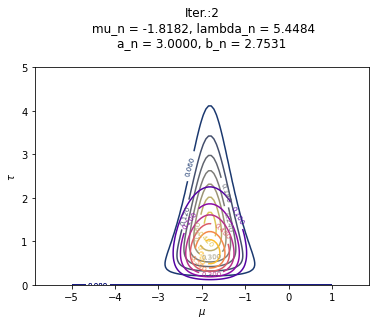

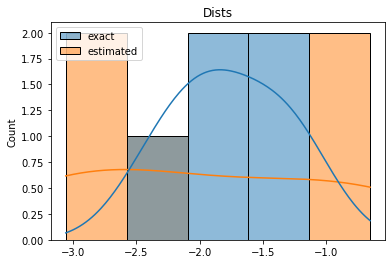

[VI ITER: 3, CONVERGENCE: no]
mu_n = -1.8182, lambda_n = 7.5371, a_n = 3.0000, b_n = 1.9902
E[mu] = -1.8182, E[tau] = 1.5074



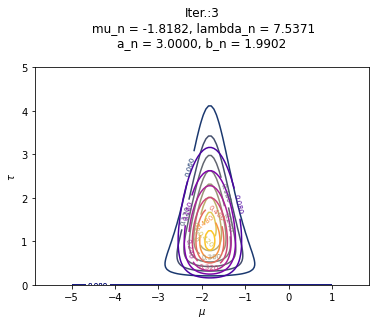

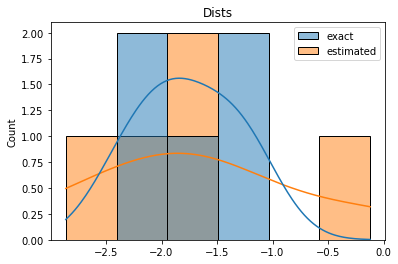

[VI ITER: 4, CONVERGENCE: no]
mu_n = -1.8182, lambda_n = 8.0515, a_n = 3.0000, b_n = 1.8630
E[mu] = -1.8182, E[tau] = 1.6103



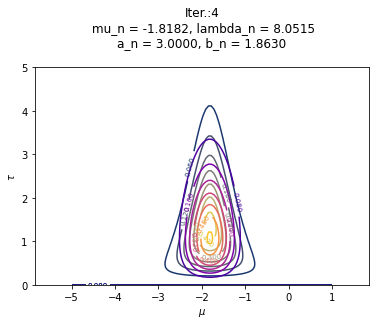

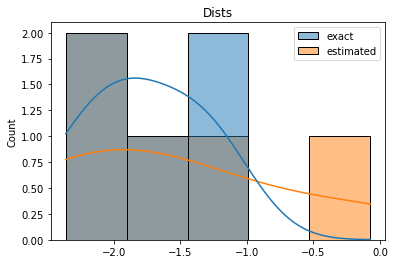

[VI ITER: 5, CONVERGENCE: no]
mu_n = -1.8182, lambda_n = 8.1442, a_n = 3.0000, b_n = 1.8418
E[mu] = -1.8182, E[tau] = 1.6288



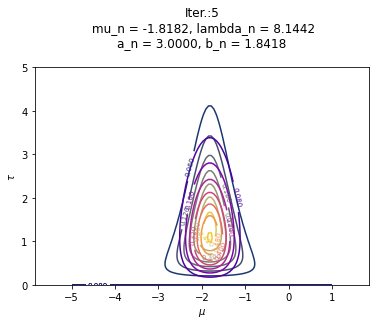

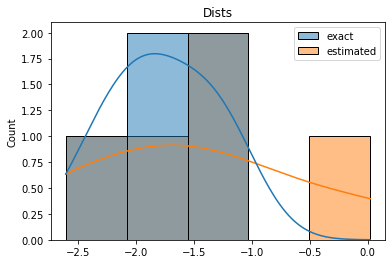

[VI ITER: 6, CONVERGENCE: no]
mu_n = -1.8182, lambda_n = 8.1598, a_n = 3.0000, b_n = 1.8383
E[mu] = -1.8182, E[tau] = 1.6320



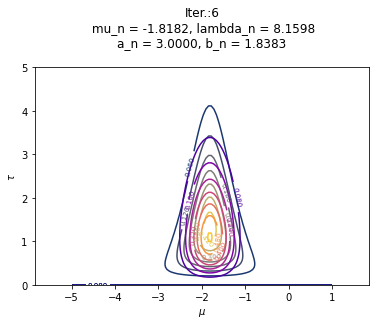

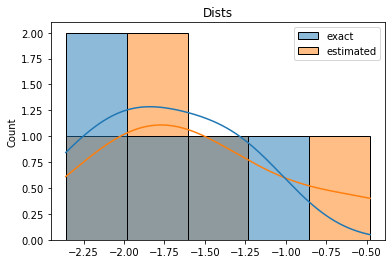

[VI ITER: 7, CONVERGENCE: no]
mu_n = -1.8182, lambda_n = 8.1624, a_n = 3.0000, b_n = 1.8377
E[mu] = -1.8182, E[tau] = 1.6325



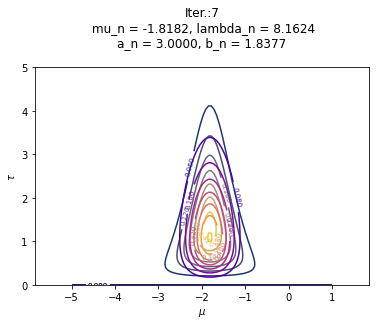

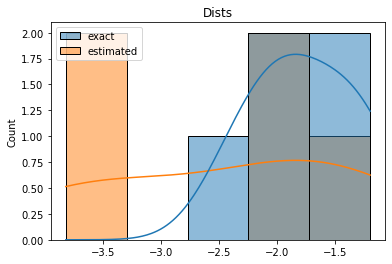

[VI ITER: 8, CONVERGENCE: no]
mu_n = -1.8182, lambda_n = 8.1629, a_n = 3.0000, b_n = 1.8376
E[mu] = -1.8182, E[tau] = 1.6326



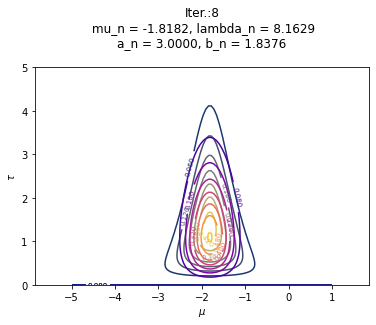

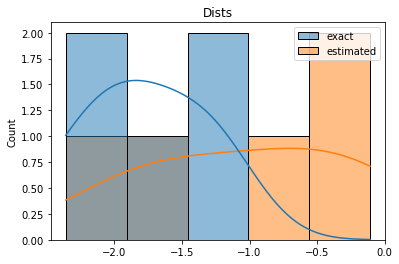

[VI ITER: 9, CONVERGENCE: no]
mu_n = -1.8182, lambda_n = 8.1629, a_n = 3.0000, b_n = 1.8376
E[mu] = -1.8182, E[tau] = 1.6326



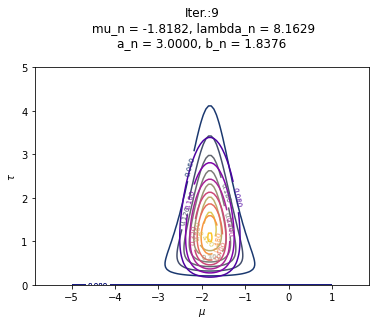

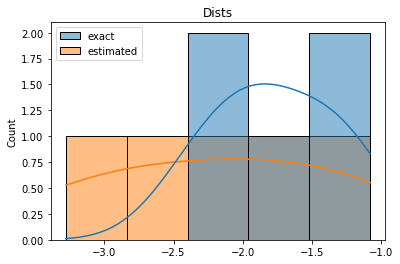

[VI ITER: 10, CONVERGENCE: no]
mu_n = -1.8182, lambda_n = 8.1629, a_n = 3.0000, b_n = 1.8376
E[mu] = -1.8182, E[tau] = 1.6326



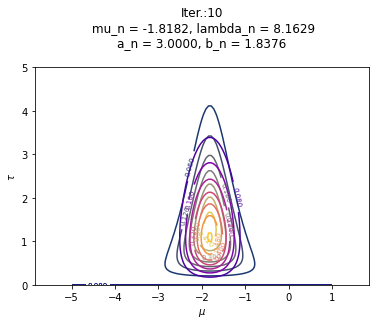

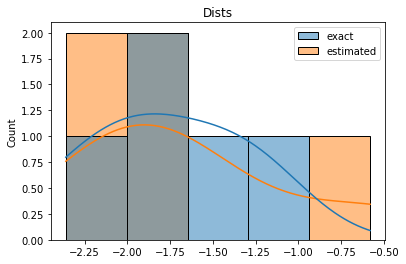

[VI ITER: 11, CONVERGENCE: yes]
mu_n = -1.8182, lambda_n = 8.1629, a_n = 3.0000, b_n = 1.8376
E[mu] = -1.8182, E[tau] = 1.6326



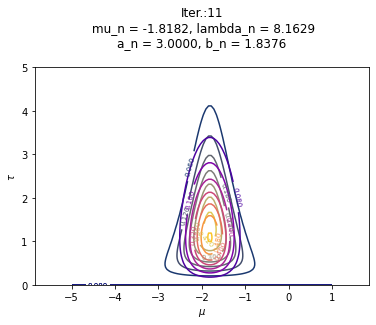

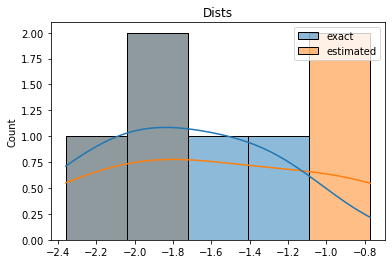

In [9]:
# Create a linear space of the parameters of the estimated posterior data
# distribution mu and tau.
# The number of values in the linear space.
n_param = 100
mu_vec = np.linspace(-5, 1, n_param)
tau_vec = np.linspace(0, 5, n_param)

# Specify the hyperparameters of the VI algorithm, and declare some variables
# that are used in it. Keeping track of the iteration number.
iter_n = 0

# The threshold for convergence.
thresh = 10e-6

# Boolean for convergence.
converged = False

# If verbose execution or not, i.e.: print stuff or not.
verbose = True

# Empty lists for keeping track of the updated parameters of
# the estimated posterior.
mu_n_register, lambda_n_register, a_n_register, b_n_register = [], [], [], []

# Initialize the conjugate priors, that is the factors, in the factorized
# distribution q. These are hyper-priors, they do not change.
a_0, b_0, mu_0, lambda_0 = 0.0, 0.0, 0.0, 0.0

# These are dummy updates. Need to specify these since updating one of the
# factors in q requires the updated parameters from the other factor.
# These change during the execution of the VI algorithm.
a_n, b_n, mu_n, lambda_n = 0.0, 0.0, 0.0, 0.1

# Compute the parameters of the exact posterior.
mu_t, lambda_t, a_t, b_t = \
    exact_posterior_params(x=x, a_0=a_0, b_0=b_0,mu_0=mu_0, lambda_0=lambda_0)

if verbose:
    print(f"Data drawn from normal distribution with mean={mean_data}, "
          f"prec={prec_data}, number of points={N_data}\n")
    print(f"[EXACT POSTERIOR]")
    print(f"mu_t = {mu_t:.4f}, lambda_t = {lambda_t:.4f} "
          f"a_t = {a_t:.4f}, b_t = {b_t:.4f}\n"
          f"E[mu]={mu_t:.4f}, E[tau]={a_t/b_t:.4f} \n")

# Compute the probability density of the exact posterior.
posterior_exact = \
    exact_posterior_dist(mu_vec_=mu_vec, tau_vec_=tau_vec,
                         mu_t=mu_t, lambda_t=lambda_t, a_t=a_t, b_t=b_t)

# Draw iid samples from the exact posterior for visualization purposes.
expected_tau_t = a_t/b_t
x_exact = generate_data(mu=mu_t, sigma=1/np.sqrt(expected_tau_t), N=N_data)

# START of the VI algorithm.
# Loop until convergence.
while not converged:
    # Update the parameters of the distribution factor over mu in the
    # factorized variational approximation, q, to the posterior distribution.
    a_n, b_n = \
        update_q_tau(x=x, mu_n=mu_n, lambda_n=lambda_n, a_0=a_0, b_0=b_0,
                     mu_0=mu_0, lambda_0=lambda_0)

    # Update the parameters of the distribution factor over mu in the
    # factorized variational approximation, q, to the posterior distribution.
    mu_n, lambda_n = \
        update_q_mu(x=x, a_n=a_n, b_n=b_n, mu_0=mu_0, lambda_0=lambda_0)

    # Append new parameter updates to lists.
    mu_n_register.append(a_n)
    lambda_n_register.append(lambda_n)
    a_n_register.append(a_n)
    b_n_register.append(b_n)

    # Starting at then 2nd iteration round, when there are at least 2 values
    # in the lists, check for convergence at each iteration.
    if 1 <= iter_n:
        converged = \
            if_converged(mu_n_register, lambda_n_register,
                         a_n_register, b_n_register, thresh=thresh)

    if verbose:
        print(f"[VI ITER: {iter_n}, "
              f"CONVERGENCE: {'yes' if converged else 'no'}]")
        print(f"mu_n = {mu_n:.4f}, lambda_n = {lambda_n:.4f}, "
              f"a_n = {a_n:.4f}, b_n = {b_n:.4f}\n"
              f"E[mu] = {mu_n:.4f}, "
              f"E[tau] = {a_n/b_n:.4f}\n")

    # Compute the normal distribution factor over mu. 
    q_mu_dist = q_mu(mu_vec, mu=mu_n, lambda_=lambda_n)

    # Compute the gamma distribution factor over tau.
    q_tau_dist = q_tau(tau_vec, a=a_n, b=b_n)

    # Compute the estimated posterior probability density over mu and tau.
    posterior_variational = np.outer(q_tau_dist, q_mu_dist)

    # Create mesh-grid for visualizing the exact, and the estimated
    # posterior distributions over mu and tau.
    mu_mesh, tau_mesh = np.meshgrid(mu_vec, tau_vec)
    
    # Plot the estimated posterior probability density over mu and tau.
    plt.figure()
    
    posterior_exact_contour = \
        plt.contour(mu_mesh, tau_mesh, posterior_exact, cmap="cividis")
    plt.clabel(posterior_exact_contour, fontsize=7, inline=1)

    posterior_variational_contour = \
        plt.contour(mu_mesh, tau_mesh, posterior_variational, cmap="plasma")
    plt.clabel(posterior_variational_contour, fontsize=7, inline=1)
    
    # The exact and estimated normal-gamma posterior over $\\mu$ and $\\tau$
    plt.title(f"Iter.:{iter_n}\n"
              f" mu_n = {mu_n:.4f}, lambda_n = {lambda_n:.4f}\n"
              f"a_n = {a_n:.4f}, b_n = {b_n:.4f}\n")
    plt.xlabel('$\\mu$')
    plt.ylabel('$\\tau$')
    plt.axis("equal")
    plt.show()

    # Plot the data distribution, the exact posterior, and the
    # estimated posterior over the data.
    x_estimated = generate_data(mu=mu_n, sigma=1/np.sqrt(a_n/b_n), N=N_data)
    df = pd.DataFrame(data={"exact":x_exact, "estimated":x_estimated})
    sns.histplot(data=df,kde=True)
    plt.title("Dists")
    plt.show()

    # Increase the iteration counter.
    iter_n += 1